In [1]:
import numpy as np
import pandas as pd 
import glob
import os 
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn as sns
from utils import procesar_metricas, summarize_metrics_by_group, summarize_metrics_for_plotting

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

%load_ext autoreload
%autoreload 2

In [11]:
models = glob.glob(os.path.join('./output_old/*', '*', 'test_metrics.toml'))

In [12]:
resultados = procesar_metricas(models, folder='output_old')

In [13]:
summary_df = summarize_metrics_by_group(resultados)

In [14]:
df_plot = summarize_metrics_for_plotting(resultados)

In [15]:
df_plot['F1_Score_error_low'] = df_plot['F1_Score_mean'] - df_plot['F1_Score_p05']
df_plot['F1_Score_error_high'] = df_plot['F1_Score_p95'] - df_plot['F1_Score_mean']

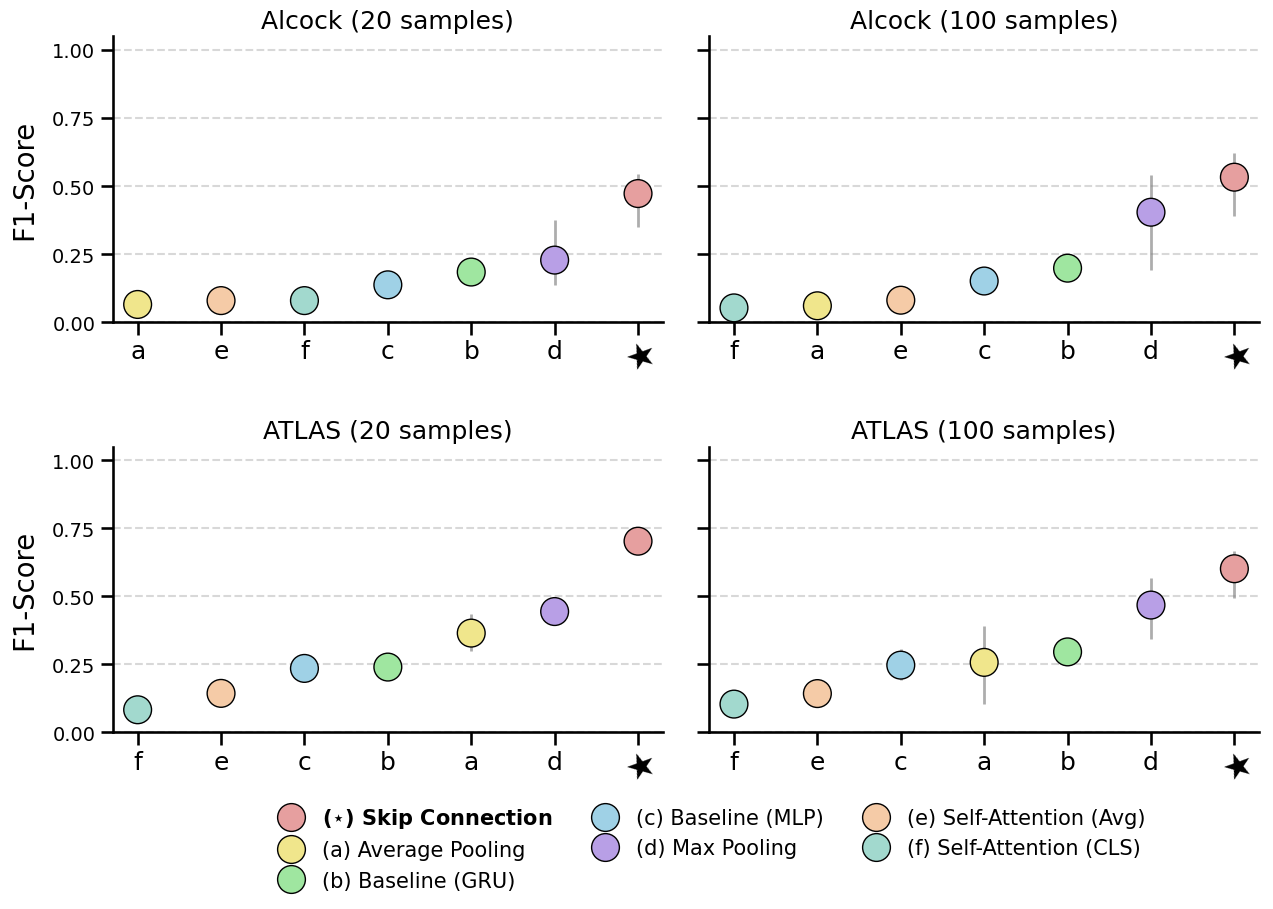

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import string

# --- 1. CONFIGURACIÓN GLOBAL ---
sns.set_context("talk", font_scale=1.1)

# --- 2. PRE-PROCESAMIENTO ---
df_plot['Dataset'] = df_plot['Dataset'].replace({'alcock': 'Alcock', 'atlas': 'ATLAS'})
df_plot['Dataset_Samples'] = df_plot['Dataset'] + ' (' + df_plot['Samples'].astype(str) + ' samples)'

name_mapping = {
    'avg': 'Average Pooling', 
    'max': 'Max Pooling', 
    'skip': 'Skip Connection',
    'att_avg': 'Self-Attention (Avg)', 
    'att_cls': 'Self-Attention (CLS)',
    'base_avgpool': 'Baseline (MLP)', 
    'base_gru': 'Baseline (GRU)', 
    'raw_gru': 'Baseline (Raw RNN)'
}
df_plot['Display_Name'] = df_plot['Classifier'].replace(name_mapping)

# --- 3. GENERACIÓN DE IDs ---
unique_models = sorted(df_plot['Display_Name'].unique())
letters = string.ascii_lowercase[:len(unique_models)]
model_to_id = dict(zip(unique_models, letters))

# ID Especial para Skip Connection (Estrella LaTeX estándar)
for model_name in model_to_id.keys():
    if 'Skip' in model_name:
        model_to_id[model_name] = r'$\star$' 

colors_hex = [
    "#E69F9F", "#F0E68C", "#9FE6A0", "#9FD1E6", 
    "#B89FE6", "#F5CBA7", "#A2D9CE", "#D7BDE2"
]

df_plot['Model_ID'] = df_plot['Display_Name'].map(model_to_id)
df_plot['Legend_Label'] = df_plot.apply(lambda x: f"({x['Model_ID']}) {x['Display_Name']}", axis=1)

unique_labels = sorted(df_plot['Legend_Label'].unique())
palette_dict = dict(zip(unique_labels, colors_hex))

# --- 4. PLOTTING ---

def ranked_scatter(data, x, y, hue, **kws):
    data = data.sort_values(by=y, ascending=True)
    ax = plt.gca()
    sns.scatterplot(data=data, x=x, y=y, hue=hue, ax=ax, **kws)
    plt.errorbar(
        data[x], data[y], 
        yerr=[data['F1_Score_error_low'], data['F1_Score_error_high']], 
        fmt='none', capsize=0, color='#777777', alpha=0.6, zorder=1, elinewidth=2
    )

g = sns.FacetGrid(
    df_plot, col="Dataset_Samples", col_wrap=2, 
    sharex=False, sharey=True, height=5, aspect=1.3
)

g.map_dataframe(
    ranked_scatter, x='Model_ID', y='F1_Score_mean', 
    hue='Legend_Label', s=400, palette=palette_dict, 
    edgecolor='k', linewidth=1, zorder=3
)

# --- 5. ESTÉTICA Y MANIPULACIÓN DE TICKS ---

g.set_axis_labels("", "F1-Score", fontweight='normal', labelpad=10)
g.set_titles(col_template="{col_name}", fontweight='normal', size=18)

for ax in g.axes.flat:
    ax.yaxis.grid(True, linestyle='--', alpha=0.3, color='gray')
    ax.xaxis.grid(False)
    ax.set_ylim(0, 1.05)
    
    plt.draw() 
    
    # --- AQUI SE ROTAN Y AGRANDAN LOS TICKS ---
    for label in ax.get_xticklabels():
        text = label.get_text()
        if 'star' in text:
            label.set_fontsize(50) # Estrella muy grande en el eje
            label.set_rotation(20) # <--- ROTACIÓN DE LA ESTRELLA (Grados)
            # Ajuste vertical fino para que la rotación no la suba demasiado
            label.set_y(label.get_position()[1] + 0.07) 
        else:
            label.set_fontsize(18)
            # label.set_fontweight('bold')
            
    plt.setp(ax.get_yticklabels(), fontsize=14)

# --- 6. LEYENDA ---
handles, labels = ax.get_legend_handles_labels()
legend_data = dict(zip(labels, handles))
sorted_labels = sorted(legend_data.keys()) 
sorted_handles = [legend_data[k] for k in sorted_labels]

# Capturamos el objeto 'leg'
leg = g.fig.legend(
    sorted_handles, 
    sorted_labels,
    # title='Model Reference', 
    title_fontsize=16, 
    loc='lower center', 
    ncol=3,  
    bbox_to_anchor=(0.55, +0.07), 
    frameon=False,
    fontsize=15, 
    columnspacing=1.5, 
    handletextpad=0.5
)

# --- MANIPULACIÓN DEL TAMAÑO EN LA LEYENDA ---
# Iteramos sobre los textos de la leyenda ya creada
for t in leg.get_texts():
    # Si el texto contiene la estrella (o el nombre del modelo Skip)
    if 'star' in t.get_text():
        # Opcional: Si quieres diferenciar el color o peso
        t.set_fontweight('bold') 

g.fig.tight_layout(rect=[0, 0.15, 1, 1.0]) 
plt.savefig('results.pdf', format='pdf', bbox_inches='tight')
plt.show()